In [145]:
import numpy as np
import scipy
from scipy.optimize import curve_fit


# Load the npz file
data = np.load('/Users/neilhazra/Downloads/pos25mT_553_50mW.npz')['data']

In [146]:
import matplotlib.pyplot as plt


In [147]:
def find_peaks_split(frame, params=[]):
    x, y= np.meshgrid(np.arange(-frame.shape[0]//2, +frame.shape[0]//2), np.arange(-frame.shape[0]//2, +frame.shape[0]//2))
    r = x**2 + y**2
    theta = np.atan2(x,y)

    thetas = np.linspace(-np.pi,np.pi, 360)
    dtheta = thetas[1] - thetas[0]
    theta_slices = []
    for i, th in enumerate(thetas):
        theta_slices.append(frame[(theta < (th + dtheta/2)) & (theta >(th - dtheta/2))].mean())
    theta_intensity = np.nan_to_num(np.array(theta_slices))
    n = 5
    convolved = scipy.ndimage.convolve(theta_intensity, [1/n]*n, mode='wrap')
    def grid_search_curve_fit(func, xdata, ydata, param_grid, prev_estimate, bounds=None):
        param_values = list(param_grid.values())
        
        # Generate all combinations of initial parameters
        from itertools import product
        param_combinations = list(product(*param_values))
        
        # Initialize variables to store the best fit
        best_params = None
        best_covariance = None
        best_error = np.inf
        
        # Loop over all parameter combinations
        for initial_guess in param_combinations + prev_estimate:
            try:
                # Fit using the current set of initial parameters
                params, covariance = curve_fit(func, xdata, ydata, p0=initial_guess)
                
                # Calculate the residual sum of squares (RSS)
                residuals = ydata - func(xdata, *params)
                rss = np.sum(residuals**2)
                
                # Check if this fit is better than the previous best
                if rss < best_error:
                    best_error = rss
                    best_params = params
                    best_covariance = covariance
            
            except RuntimeError:
                print('not convergred')
                # Catch the case where curve_fit fails to converge for certain parameter sets
                pass
        return best_params, best_covariance, best_error

    # Define the function for a mixture of Gaussian peaks distributed at angles in degrees
    def gaussian_mixture(x, w1, sigma1, theta1_start, w2, theta2_start):
        # Convert angles to radians for computation (since Gaussians use squared distance)
        x_rad = np.radians(x)
        
        # First set of 6 peaks (60 degrees apart)
        peaks1 = [(theta1_start + i * 60) % 360 for i in range(6)]
        
        # Second set of 6 peaks (60 degrees apart)
        peaks2 = [(theta2_start + i * 60) % 360 for i in range(6)]
        
        # Convert peak angles to radians
        peaks1_rad = np.radians(peaks1)
        peaks2_rad = np.radians(peaks2)
        
        # Gaussian contributions from the first set of peaks
        gaussian1 = np.zeros_like(x_rad)
        for peak in peaks1_rad:
            gaussian1 += w1 * np.exp(-0.5 * ((x_rad - peak) / sigma1)**2) / np.sqrt(2 * np.pi * sigma1**2)
        
        # Gaussian contributions from the second set of peaks
        gaussian2 = np.zeros_like(x_rad)
        for peak in peaks2_rad:
            gaussian2 += w2 * np.exp(-0.5 * ((x_rad - peak) / sigma1)**2) / np.sqrt(2 * np.pi * sigma1**2)
        
        # Total mixture of both sets of peaks
        return gaussian1 + gaussian2 + np.mean(convolved) * 2/3

    param_grid = {
        'w1': [0.25, 0.5, 1],   # Variations around 40
        'sigma1': [0.008, 0.01, 0.02],  # Variations around 1
        'mu1': [np.argmax(convolved)],  # Variations around 20
        'w2': [0.25, 0.5, 1],   # Variations around 20
        'mu2': [np.argmax(convolved) - 15, np.argmax(convolved) - 10, np.argmax(convolved) + 10, np.argmax(convolved) + 15],  # Variations around 50
    }

    params, _, _ = grid_search_curve_fit(gaussian_mixture, np.arange(convolved.shape[0]), convolved, param_grid=param_grid, prev_estimate=params)
    print(params)
    w1_fit, sigma1_fit,mu1_fit, w2_fit, mu2_fit = params
    fitted_pdf = gaussian_mixture(np.arange(convolved.shape[0]), w1_fit, sigma1_fit, mu1_fit, w2_fit, mu2_fit)
    return mu1_fit % 60, mu2_fit % 60, fitted_pdf, convolved, params

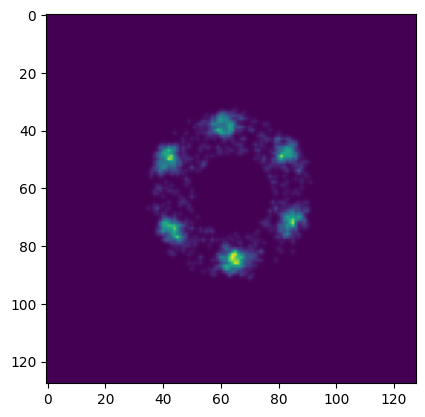

In [148]:
frame = data[250]
frame = data[225]
frame = data[109]
plt.imshow(frame)

/var/folders/y6/dcvw5tyn609_4w5cdgrwktw00000gp/T/ipykernel_53041/83174209.py:10: RuntimeWarning: Mean of empty slice.
  theta_slices.append(frame[(theta < (th + dtheta/2)) & (theta >(th - dtheta/2))].mean())
/Users/neilhazra/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[ 7.85049985e+00  1.50679229e-01  1.81393165e+02 -2.71280204e+00
  1.59539801e+02]
1.393165420662399 39.539801292678476


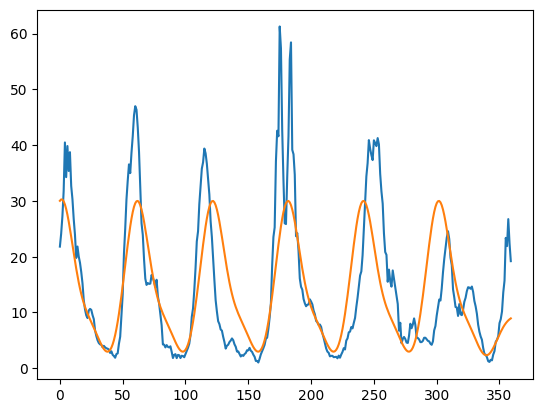

In [158]:
theta_1, theta_2, fitted_pdf, theta_intensity, params = find_peaks_split(data[275])
print(theta_1, theta_2)
plt.plot(theta_intensity)
plt.plot(fitted_pdf)
plt.show()

/var/folders/y6/dcvw5tyn609_4w5cdgrwktw00000gp/T/ipykernel_53041/83174209.py:10: RuntimeWarning: Mean of empty slice.
  theta_slices.append(frame[(theta < (th + dtheta/2)) & (theta >(th - dtheta/2))].mean())


[3.64579539e+00 1.73183306e-01 1.80000000e+02 1.47124138e+00
 2.04073507e+02]
0 out of 299
[14.68417214  0.57259082 21.71973299 -9.86698251 59.99996292]
1 out of 299
[ 4.64256741  0.12793977 20.65085068  0.57248402 38.03980181]
2 out of 299
[  5.96177479   0.12128709  78.01016267  -0.96151969 110.41181127]
3 out of 299
[13.90429865  0.19470157  8.34086882 -8.83563033 60.00000063]
4 out of 299
[ 7.67390573e+00  1.82081347e-01  1.94118347e+02 -2.37400128e+00
  1.62724806e+02]
5 out of 299
[ 71.3118431    0.26821833 262.75135497 -66.14109422 265.58911774]
6 out of 299
[ 42.74379483   0.26683189  20.9328796  -37.94717725  24.07494468]
7 out of 299
not convergred
not convergred
[ 3.53475985  0.10569938 18.23456753  1.69184792  1.24407786]
8 out of 299
[ 7.06692988  0.15049971 12.88008418 -2.19460893 38.20645768]
9 out of 299
[ 7.40671639e+00  1.16634490e-01  1.86607969e+02 -1.90414413e+00
  1.56859280e+02]
10 out of 299
[ 6.71141174  0.12043451 62.26369641 -1.42892067 94.31060481]
11 out of

/var/folders/y6/dcvw5tyn609_4w5cdgrwktw00000gp/T/ipykernel_53041/83174209.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(func, xdata, ydata, p0=initial_guess)


[ 1.25523033e+01  2.62382288e-01  1.10578099e+01 -7.55456193e+00
 -6.02167119e-08]
121 out of 299
[ 89.72766331   0.33049834 265.70219959 -84.43948129 269.32265121]
122 out of 299
[ 7.09200764e+00  1.69324992e-01  1.93372720e+02 -1.80911957e+00
  2.17461383e+02]
123 out of 299
[ 8.67223071e+00  1.87651042e-01  2.51317551e+02 -3.42955471e+00
  2.72957722e+02]
124 out of 299
[ 70.93290039   0.23985042 197.13338421 -65.53788207 138.77986079]
125 out of 299
[ 6.08740041  0.15306936 65.25200643 -0.98367543 93.42527155]
126 out of 299
[ 2.7867604   0.08558284 64.01813397  2.44862624 54.22113514]
127 out of 299
[2.89490883e+00 1.03651129e-01 1.71901875e+02 1.39435277e+00
 1.87842381e+02]
128 out of 299
[ 1.05779517e+01  2.98555897e-01  2.54244679e+02 -5.51676409e+00
  2.99999986e+02]
129 out of 299
[ 8.58834218  0.15873863 13.76960193 -2.88888083 42.89145432]
130 out of 299
[ 7.59176479e+00  1.60666988e-01  1.89083208e+02 -2.48968879e+00
  1.63812075e+02]
131 out of 299
[ 6.98659697e+00  1.68

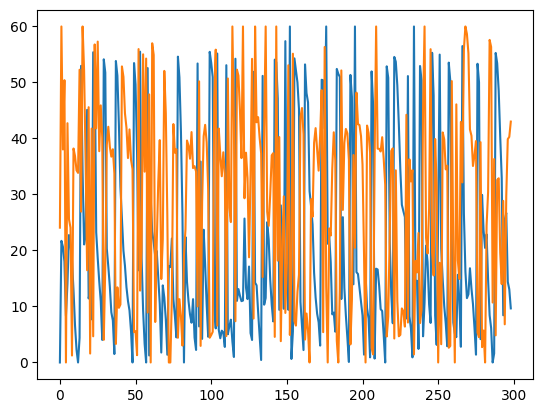

In [153]:
theta_1s =  []
theta_2s = []
prev = None
frames = []
for i, frame in enumerate(data):
    if prev is None:   
        theta_1, theta_2, _ , _, prev = find_peaks_split(frame, [prev])
    else:
        theta_1, theta_2, _ , _, prev = find_peaks_split(frame)
    theta_1s.append(theta_1)
    theta_2s.append(theta_2)
    frames.append(i)
    print(i, 'out of', len(data))

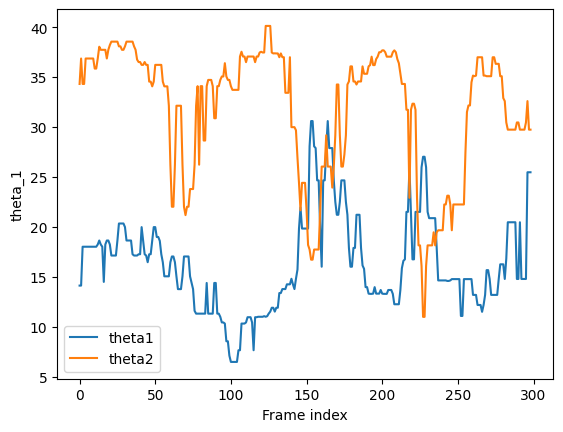

In [157]:
from scipy.ndimage import median_filter

plt.plot(frames, median_filter(theta_1s, 25), label='theta1')
plt.plot(frames,  median_filter(theta_2s, 25), label = 'theta2')
plt.xlabel('Frame index')
plt.ylabel('theta_1')
plt.legend()
plt.show()